In [1]:
from datasets import load_dataset
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

2023-09-09 08:31:10.563249: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Using this dataset from Huggingface: "Matthijs/snacks"

In [2]:
dataset = load_dataset("Matthijs/snacks")

# Extract images and labels
images = dataset['train']['image']
labels = dataset['train']['label']

In [3]:
# process the data
def resize_and_normalize(images):
    resized_images = []
    for img in images:
        if not isinstance(img, Image.Image):
            img = Image.fromarray(img)
        resized_img = img.resize((224, 224))
        resized_images.append(np.array(resized_img))
    return np.array(resized_images) / 255.0

images = resize_and_normalize(images)
test_images = resize_and_normalize(dataset['test']['image'])

In [4]:
# Create base CNN
def create_base_network(input_shape):
    base_input = Input(input_shape)
    x = Conv2D(32, (3,3), activation='relu')(base_input)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    return Model(inputs=base_input, outputs=x)

Loss func with $\alpha=0.2$:
$$L=max(0, ||f(anchor)-f(positive)||^2-||f(anchor)-f(negative)||^2+\alpha)$$

In [5]:
# Triplet loss function
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:, :128], y_pred[:, 128:256], y_pred[:, 256:]
    positive_distance = tf.reduce_mean(tf.square(anchor - positive), axis=-1)
    negative_distance = tf.reduce_mean(tf.square(anchor - negative), axis=-1)
    return tf.maximum(positive_distance - negative_distance + 0.2, 0.)


## Training a siamese network with a triplet loss

In [6]:
# Create Siamese network
input_shape = (224, 224, 3)
base_network = create_base_network(input_shape)

anchor_input = Input(input_shape)
positive_input = Input(input_shape)
negative_input = Input(input_shape)

anchor_embedding = base_network(anchor_input)
positive_embedding = base_network(positive_input)
negative_embedding = base_network(negative_input)

merged_vector = tf.keras.layers.concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1)
siamese_network = Model(inputs=[anchor_input, positive_input, negative_input], outputs=merged_vector)
siamese_network.compile(optimizer=Adam(0.0001), loss=triplet_loss)


In [7]:
# my new func
def create_triplets(images, labels):
    anchor_images = []
    positive_images = []
    negative_images = []
    
    unique_labels = np.unique(labels)
    
    for label in unique_labels:
        same_class_idx = np.where(labels == label)[0]
        diff_class_idx = np.where(labels != label)[0]
        
        for idx in same_class_idx:
            anchor_images.append(images[idx])
            positive_images.append(images[np.random.choice(same_class_idx)])
            negative_images.append(images[np.random.choice(diff_class_idx)])
    
    return np.array(anchor_images), np.array(positive_images), np.array(negative_images)

# Generate anchor, positive, and negative images using the create_triplets function
anchor_images, positive_images, negative_images = create_triplets(images, labels)



In [8]:

# Train the Siamese network

siamese_network.fit([anchor_images, positive_images, negative_images], np.zeros(len(anchor_images)), epochs=10, batch_size=32)

Epoch 1/10
152/152 [==============================] - 236s 2s/step - loss: 0.1989
Epoch 2/10
152/152 [==============================] - 228s 1s/step - loss: 0.1889
Epoch 3/10
152/152 [==============================] - 229s 2s/step - loss: 0.1786
Epoch 4/10
152/152 [==============================] - 228s 2s/step - loss: 0.1695
Epoch 5/10
152/152 [==============================] - 217s 1s/step - loss: 0.1585
Epoch 6/10
152/152 [==============================] - 215s 1s/step - loss: 0.1461
Epoch 7/10
152/152 [==============================] - 221s 1s/step - loss: 0.1339
Epoch 8/10
152/152 [==============================] - 220s 1s/step - loss: 0.1190
Epoch 9/10
152/152 [==============================] - 215s 1s/step - loss: 0.1047
Epoch 10/10
152/152 [==============================] - 204s 1s/step - loss: 0.0952


## Image data should be persisten in an appropriate storage for later use

In [39]:
# Extract embeddings for the training images
train_embeddings = base_network.predict(images)

# Save the embeddings to a .npy file
np.save('train_embeddings.npy', train_embeddings)

# loaded_embeddings = np.load('train_embeddings.npy')

152/152 [==============================] - 23s 146ms/step


In [9]:

test_embeddings = base_network.predict(test_images)


30/30 [==============================] - 5s 160ms/step


## Fetching the most similar images to an input image

In [58]:


def get_most_similar_images(new_image, all_embeddings, top_k=5):
    # Get the embedding for the new image
    new_image_embedding = base_network.predict(np.expand_dims(new_image, axis=0))

    # Compute distances between the new image embedding and all other embeddings
    distances = np.linalg.norm(all_embeddings - new_image_embedding, axis=1)
    sorted_indices = np.argsort(distances)
    
    return sorted_indices[:top_k]


'''
test_image_embedding = base_network.predict(np.expand_dims(test_image, axis=0))
similar_image_indices = get_most_similar_images(test_image_embedding, test_embeddings)'''

test_image = test_images[8]
# Find the most similar images
similar_image_indices = get_most_similar_images(test_image, train_embeddings)




1/1 [==============================] - 3s 3s/step


## show image similarity search example

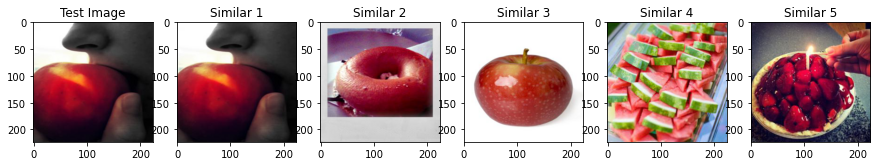

In [ ]:

def display_similar_images(test_image, similar_images):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(similar_images) + 1, 1)
    plt.imshow(test_image)
    plt.title("Test Image")
    
    for i, img_idx in enumerate(similar_image_indices, 2):
        plt.subplot(1, len(similar_images) + 1, i)
        plt.imshow(test_images[img_idx])
        plt.title(f"Similar {i-1}")
    
    plt.show()

display_similar_images(test_image, test_images[similar_image_indices])
